In [44]:

#import section
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import urllib.request
from io import StringIO, BytesIO


In [45]:
#import dataset and create dataframe
link="https://archive.ics.uci.edu/ml/machine-learning-databases/00264/EEG%20Eye%20State.arff"
resp= urllib.request.urlopen(link)
data, meta = arff.loadarff(StringIO(resp.read().decode('utf-8')))
df = pd.DataFrame(data)

In [46]:
#set the labels
for i,j in enumerate(df["eyeDetection"]):
  if j==b'0':
    df.iloc[i,-1]="0"
  else:
    df.iloc[i,-1]="1"
  

In [47]:
#distinct values and count
labels, count=np.unique(df["eyeDetection"],return_counts=True)
print(f"possible values for target variable are {labels}")
print(f"The counting for target variable are {count}")

possible values for target variable are ['0' '1']
The counting for target variable are [8257 6723]


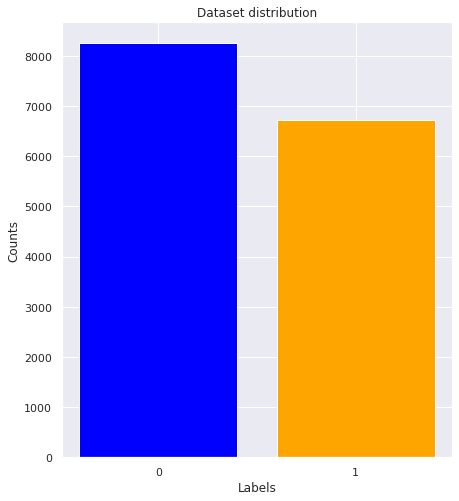

In [48]:
#print the distribution of the target variable

data = count
plt.figure(figsize=(7,8))
plt.bar(labels, data,color=["blue","orange"])

plt.ylabel('Counts')
plt.xlabel('Labels')
plt.title('Dataset distribution')
plt.savefig('datasetdistribution.png')
plt.show()


In [49]:
#feature statistics
print(df.describe())


                 AF3            F7            F3            FC5            T7  \
count   14980.000000  14980.000000  14980.000000   14980.000000  14980.000000   
mean     4321.917777   4009.767694   4264.022433    4164.946326   4341.741075   
std      2492.072174     45.941672     44.428052    5216.404632     34.738821   
min      1030.770000   2830.770000   1040.000000    2453.330000   2089.740000   
25%      4280.510000   3990.770000   4250.260000    4108.210000   4331.790000   
50%      4294.360000   4005.640000   4262.560000    4120.510000   4338.970000   
75%      4311.790000   4023.080000   4270.770000    4132.310000   4347.180000   
max    309231.000000   7804.620000   6880.510000  642564.000000   6474.360000   

                  P7             O1            O2             P8  \
count   14980.000000   14980.000000  14980.000000   14980.000000   
mean     4644.022379    4110.400160   4616.056904    4218.826610   
std      2924.789537    4600.926543     29.292603    2136.408523  

In [50]:
#check if there are null values
df.isnull().values.any()

False

In [51]:
name_feat=df.iloc[:,:-1].columns #name of features

In [52]:
#removing outliers
df_norm=zscore(df.iloc[:,:-1])
z = np.abs(df_norm)
outliers=df[~(z < 3).all(axis=1)] #outliers
df_wout=df[(z < 3).all(axis=1)] #without outliers
df_wout=pd.DataFrame(df_wout)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


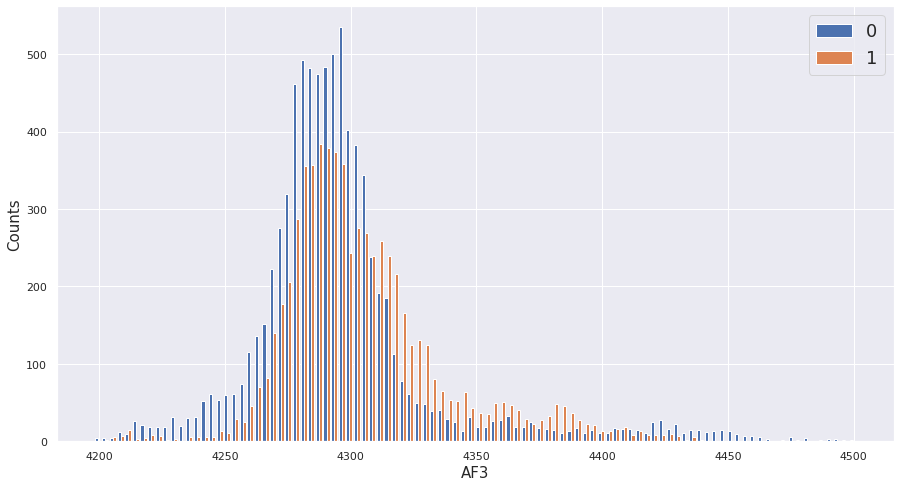

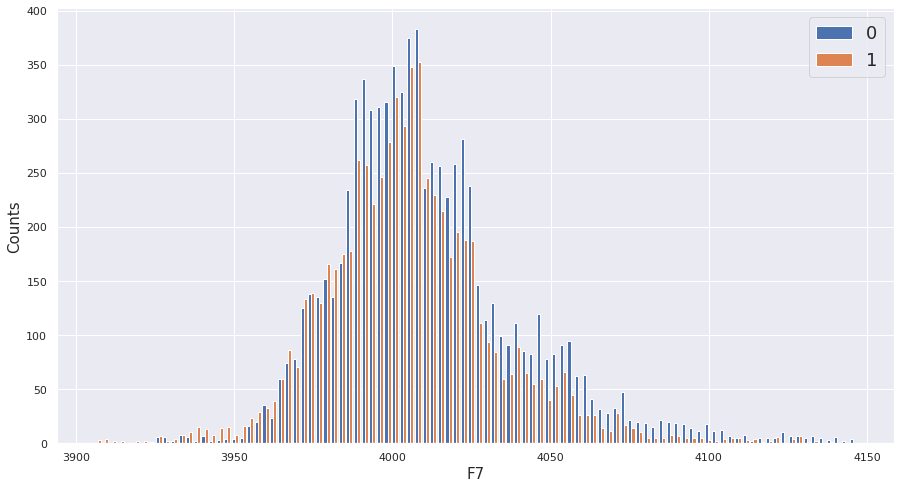

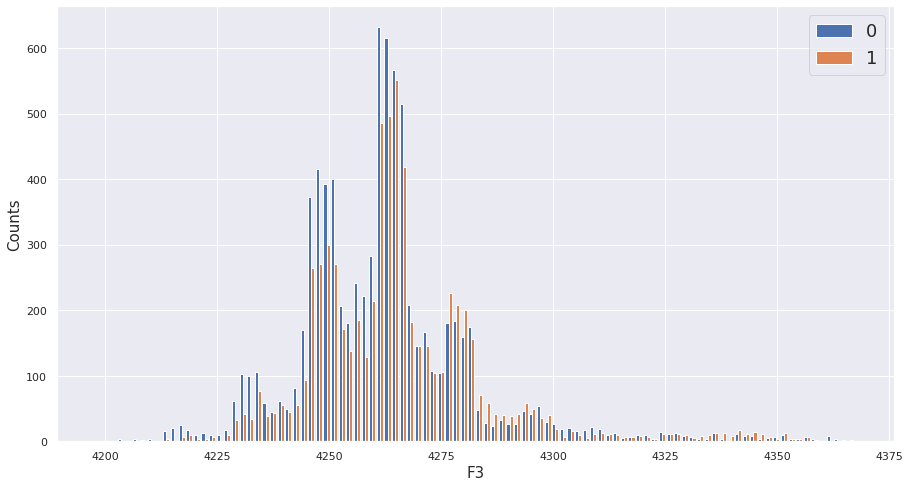

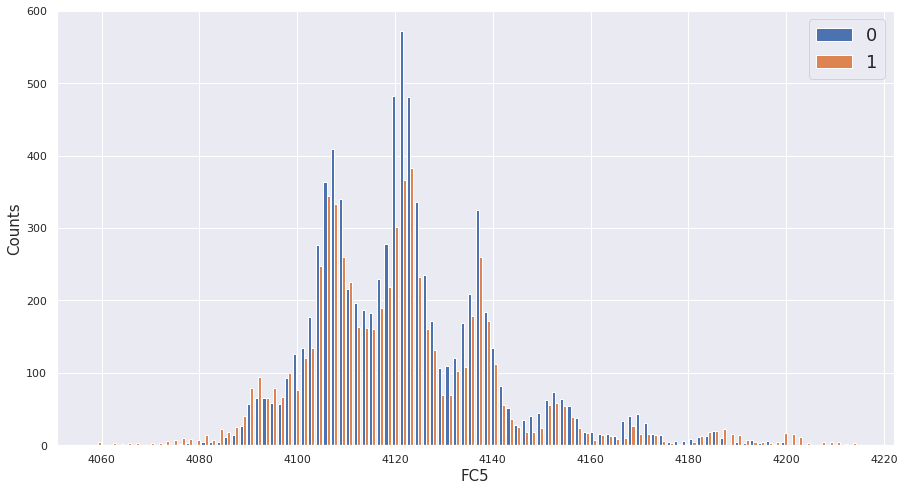

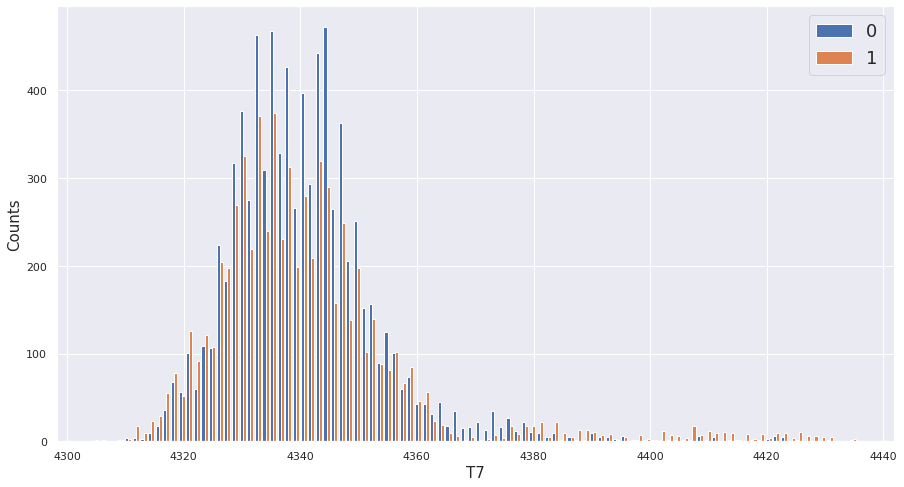

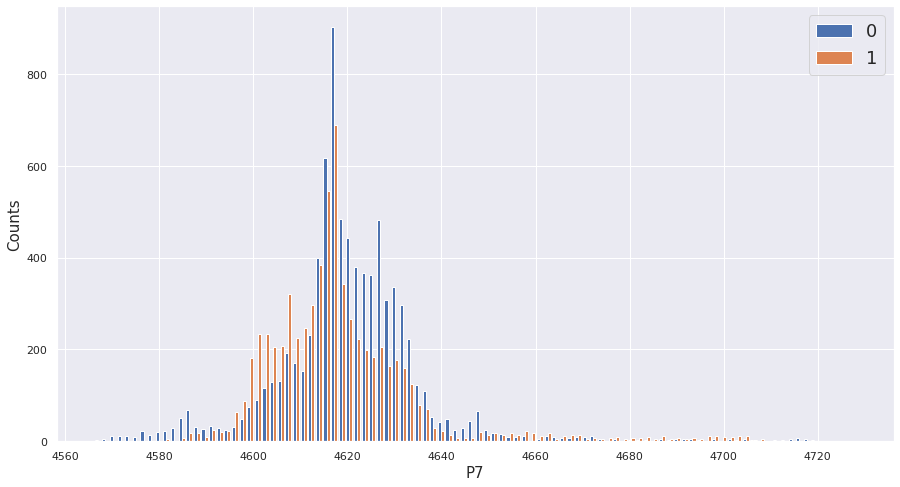

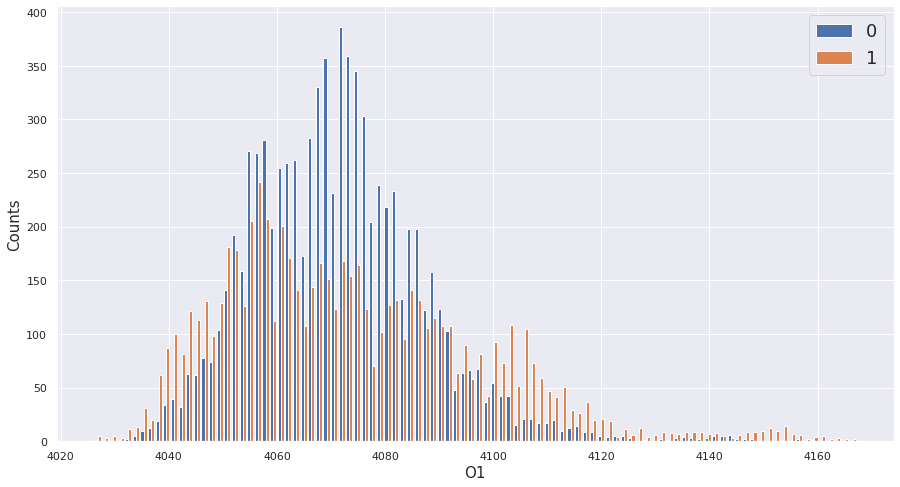

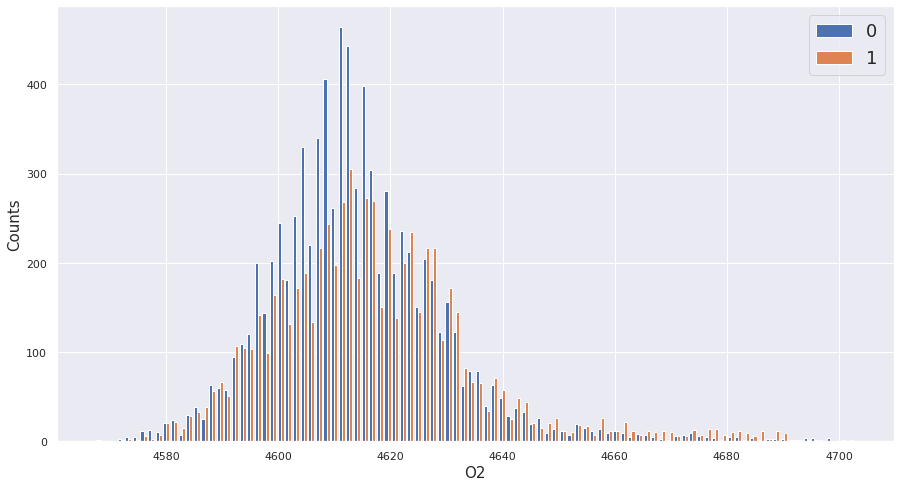

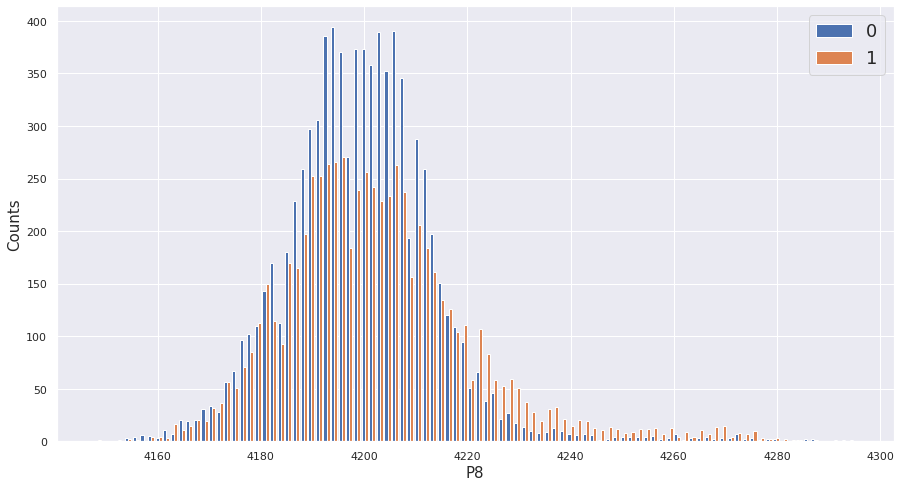

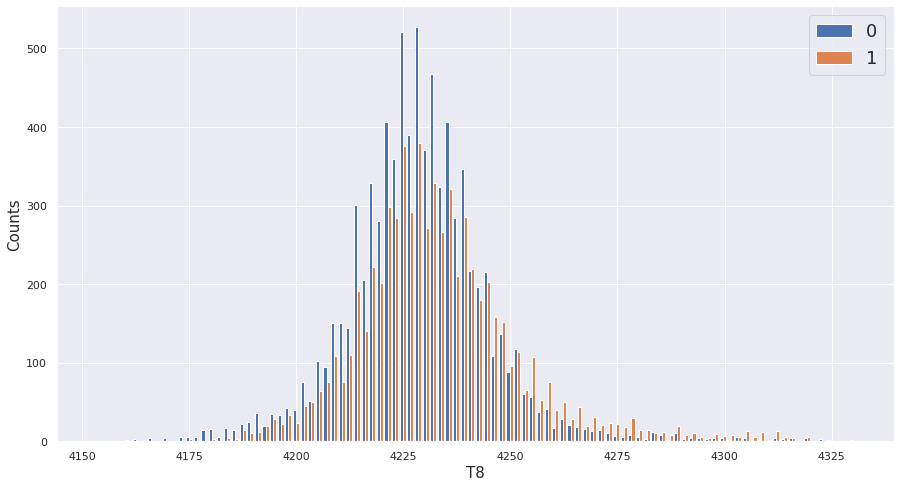

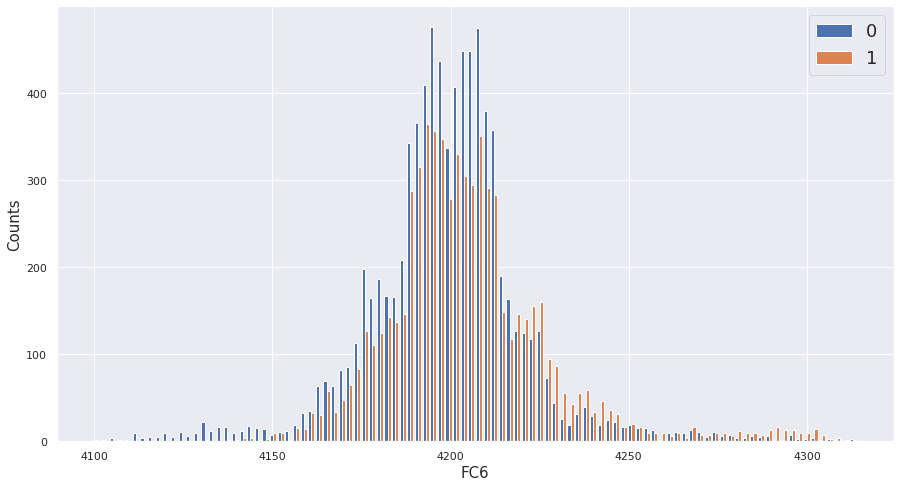

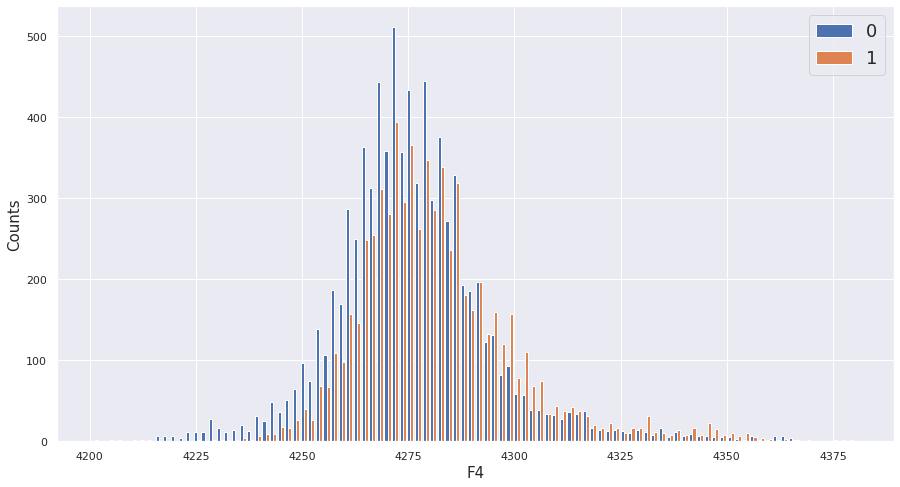

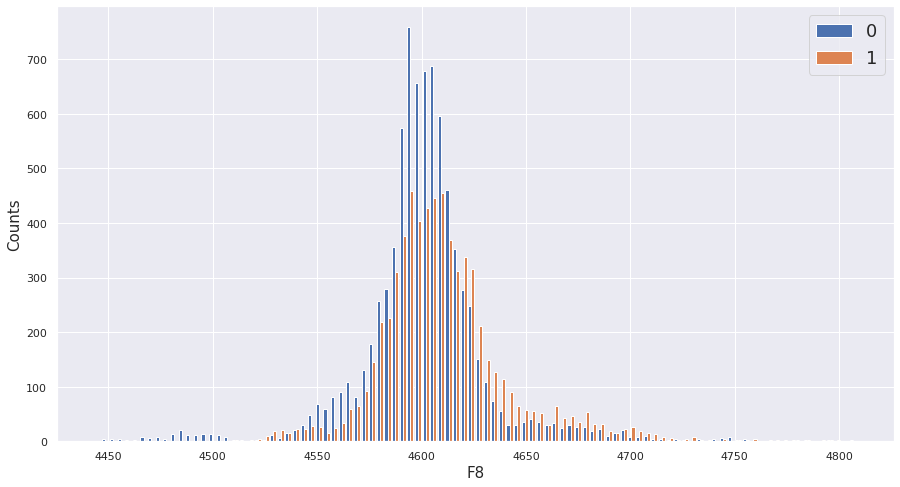

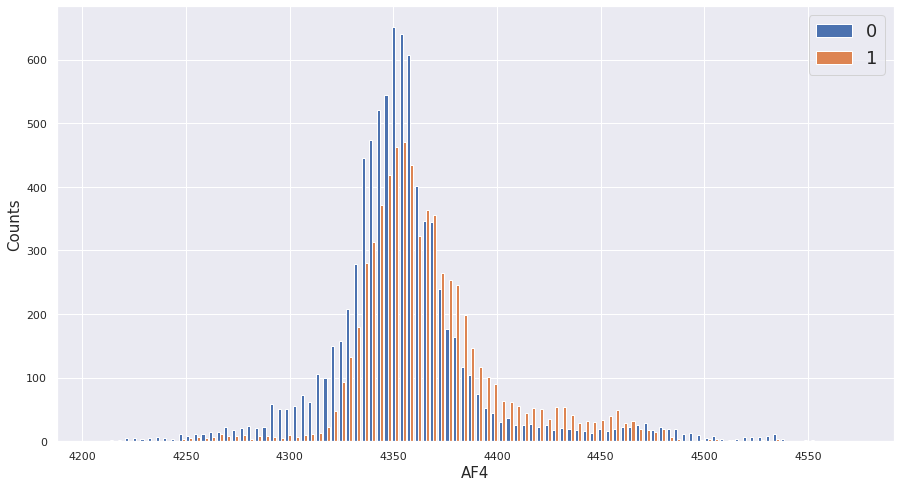

In [53]:
#plotting features distributions with removing outliers
yes=df_wout.loc[df["eyeDetection"]=="1"]
no=df_wout.loc[df["eyeDetection"]=="0"]
for i in name_feat:
    plt.figure(figsize=(15,8))
    data=[no[i],yes[i]]
    plt.hist(data,bins=100)

    plt.ylabel('Counts',fontsize=15)
    plt.xlabel(i,fontsize=15)
    
    plt.legend(["0","1"],fontsize=18)
    plt.savefig(f'distribution{i}.png')
    plt.show()

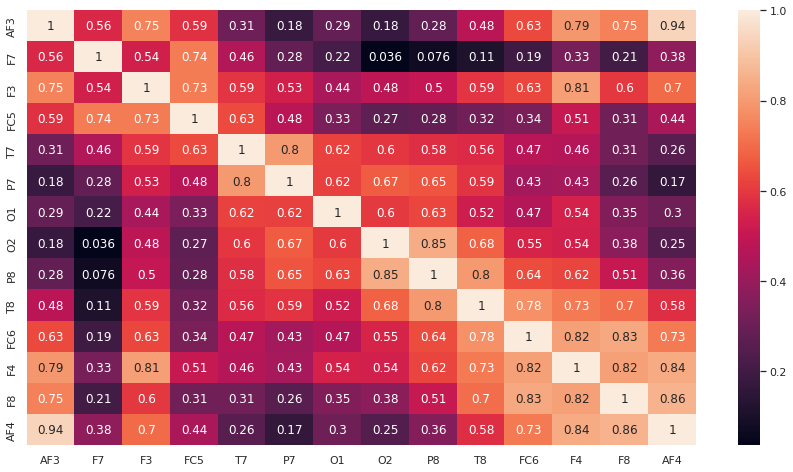

In [54]:
#confusion matrix
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df_wout.corr(),annot=True)
plt.savefig('correlation_matrix.png')

In [55]:
#train test split
X=df_wout.iloc[:,:-1]
Y=df_wout.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [56]:
#Normalization
scaler = MinMaxScaler()
X_train_norm=scaler.fit_transform(X_train)
X_test_norm=scaler.transform(X_test)

In [57]:
#import section models
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

In [77]:
best_precision=[]
best_recall=[]

In [81]:
#decision tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred=clf.predict(X_test) 
print("decision tree f1 score: "+str(f1_score(y_test, y_pred, average='macro')))
cm=confusion_matrix(y_pred,y_test)

decision tree f1 score: 0.8290987450519526


The best hyperparameters are: {'criterion': 'entropy', 'max_depth': None, 'splitter': 'best'}
decision tree tuned f1 score: 0.8310303894846779


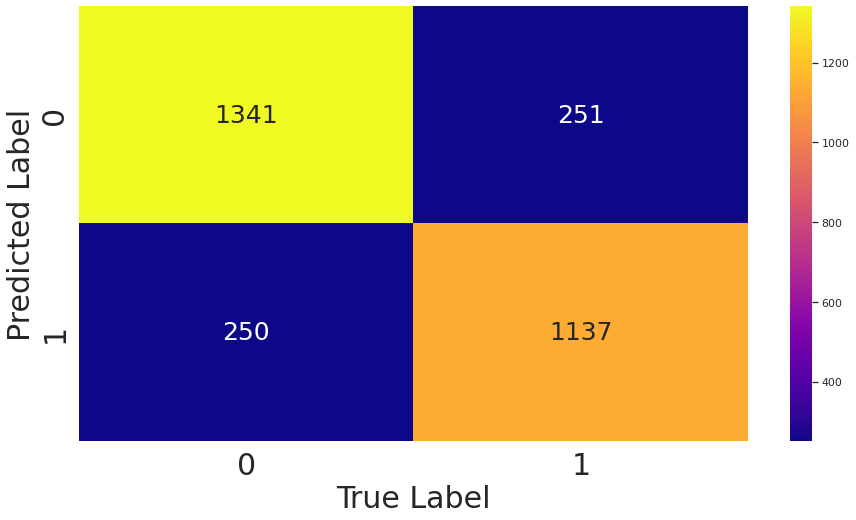

In [82]:
#greed search decision tree
param=[{"criterion":["gini", "entropy"],
       "splitter":["best", "random"],
      "max_depth":[None,10]}]
gs=GridSearchCV(clf,param,scoring="f1_macro")
gs=gs.fit(X_train_norm, y_train)
best_p=gs.best_params_
print("The best hyperparameters are: "+str(gs.best_params_))
best_model=gs.best_estimator_
y_pred=best_model.predict(X_test_norm) 
print("decision tree tuned f1 score: "+str(f1_score(y_test, y_pred, average='macro')))
cm=confusion_matrix(y_pred,y_test)
plt.figure(figsize=(15,8))
sns.heatmap(cm,annot=True,cmap="plasma",fmt="g",annot_kws={"size": 25})
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel("True Label",fontsize=30)
plt.ylabel("Predicted Label",fontsize=30)
plt.savefig("confusion_m_dt")
best_precision.append(precision_score(y_pred,y_test,average='macro'))
best_recall.append(recall_score(y_pred,y_test,average='macro'))


In [83]:
#random forest
clf = RandomForestClassifier(n_estimators=500)
clf = clf.fit(X_train_norm, y_train)
y_pred=clf.predict(X_test_norm) 
print("random forest f1 score: "+str(f1_score(y_test, y_pred, average='macro')))
cm=confusion_matrix(y_pred,y_test)

random forest f1 score: 0.9388377355990787


The best hyperparameters are: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 300}
random forest tuned f1 score: 0.9381550907241768


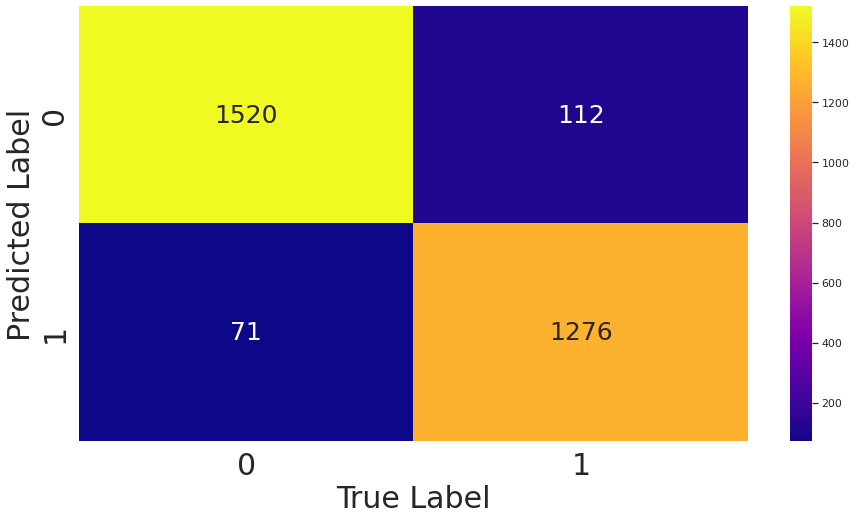

In [84]:
#grid search random forest
param=[{"criterion":["gini", "entropy"],
       "n_estimators":[100,300,500],
      "max_depth":[None,10]}]
gs=GridSearchCV(clf,param,scoring="f1_macro")
gs=gs.fit(X_train_norm, y_train)
best_p=gs.best_params_
print("The best hyperparameters are: "+str(gs.best_params_))
best_model=gs.best_estimator_
y_pred=best_model.predict(X_test_norm) 
print("random forest tuned f1 score: "+str(f1_score(y_test, y_pred, average='macro')))
cm=confusion_matrix(y_pred,y_test)

sns.heatmap(cm,annot=True,cmap="plasma",fmt="g",annot_kws={"size": 25})
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel("True Label",fontsize=30)
plt.ylabel("Predicted Label",fontsize=30)
plt.savefig("confusion_m_rf")

best_precision.append(precision_score(y_pred,y_test,average='macro'))
best_recall.append(recall_score(y_pred,y_test,average='macro'))

Support Vector Machine f1 score: 0.8905514043853966


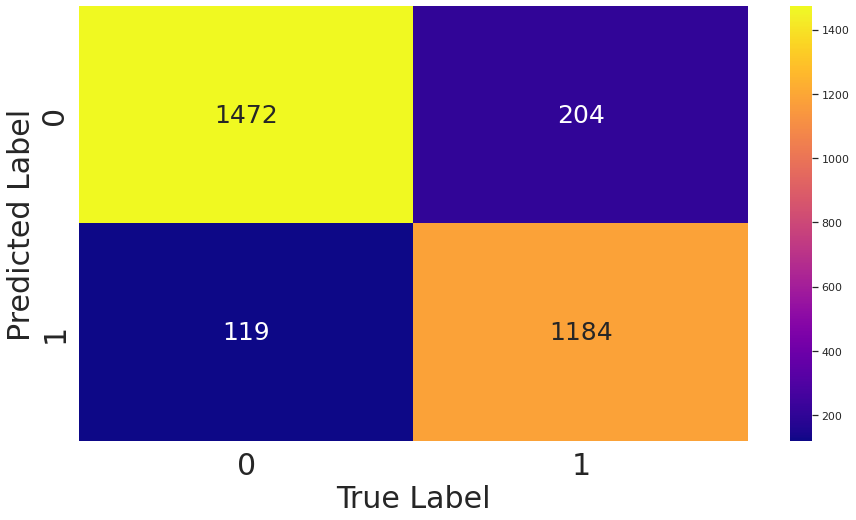

In [85]:
#Support Vector Machine
clf = SVC()
clf = clf.fit(X_train_norm, y_train)
y_pred=clf.predict(X_test_norm) 
print("Support Vector Machine f1 score: "+str(f1_score(y_test, y_pred, average='macro')))
cm=confusion_matrix(y_pred,y_test)
sns.heatmap(cm,annot=True,cmap="plasma",fmt="g",annot_kws={"size": 25})
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel("True Label",fontsize=30)
plt.ylabel("Predicted Label",fontsize=30)
plt.savefig("confusion_m_sv")
best_precision.append(precision_score(y_pred,y_test,average='macro'))
best_recall.append(recall_score(y_pred,y_test,average='macro'))

In [86]:
#Logistic Regression
clf = LogisticRegression()
clf = clf.fit(X_train_norm, y_train)
y_pred=clf.predict(X_test_norm) 
print("Logistic Regression f1 score: "+str(f1_score(y_test, y_pred, average='macro')))
cm=confusion_matrix(y_pred,y_test)

Logistic Regression f1 score: 0.609627202062787


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver

The best hyperparameters are: {'C': 1, 'penalty': 'l2'}
Logistic Regression tuned f1 score: 0.609627202062787


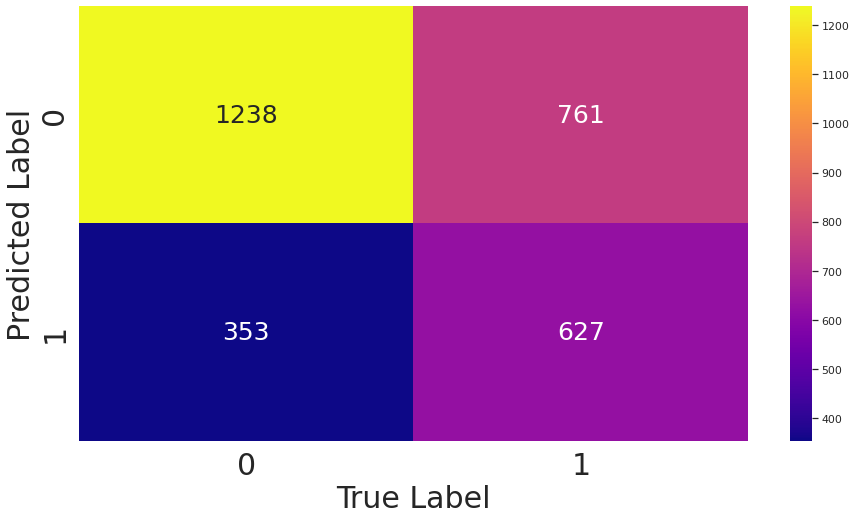

In [87]:
#grid search logistic regressor
param=[{"C":[0.5,1],
       "penalty":["l1","l2"]}]
gs=GridSearchCV(clf,param,scoring="f1_macro")
gs=gs.fit(X_train_norm, y_train)
best_p=gs.best_params_
print("The best hyperparameters are: "+str(gs.best_params_))
best_model=gs.best_estimator_
y_pred=best_model.predict(X_test_norm) 
print("Logistic Regression tuned f1 score: "+str(f1_score(y_test, y_pred, average='macro')))
cm=confusion_matrix(y_pred,y_test)
sns.heatmap(cm,annot=True,cmap="plasma",fmt="g",annot_kws={"size": 25})
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel("True Label",fontsize=30)
plt.ylabel("Predicted Label",fontsize=30)
plt.savefig("confusion_m_lr")
best_precision.append(precision_score(y_pred,y_test,average='macro'))
best_recall.append(recall_score(y_pred,y_test,average='macro'))

In [88]:
#KNN
clf = KNeighborsClassifier()
clf = clf.fit(X_train_norm, y_train)
y_pred=clf.predict(X_test_norm) 
print("KNN f1 score: "+str(f1_score(y_test, y_pred, average='macro')))
cm=confusion_matrix(y_pred,y_test)

KNN f1 score: 0.9574783015336875


The best hyperparameters are: {'n_neighbors': 5, 'weights': 'distance'}
KNN tuned f1 score: 0.9588362174416518


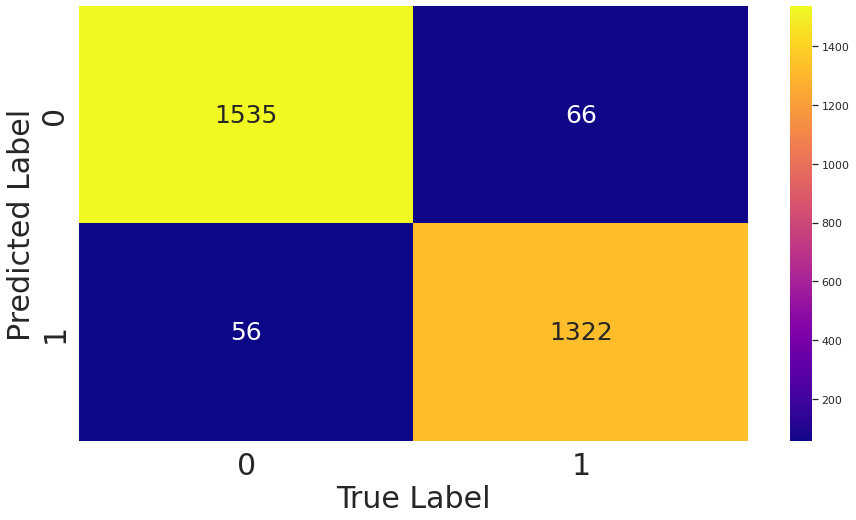

In [89]:
#grid search KNN
param=[{"n_neighbors":[5,10,15],
       "weights":["uniform","distance"]}]
gs=GridSearchCV(clf,param,scoring="f1_macro")
gs=gs.fit(X_train_norm, y_train)
best_p=gs.best_params_
print("The best hyperparameters are: "+str(gs.best_params_))
best_model=gs.best_estimator_
y_pred=best_model.predict(X_test_norm) 
print("KNN tuned f1 score: "+str(f1_score(y_test, y_pred, average='macro')))
cm=confusion_matrix(y_pred,y_test)
sns.heatmap(cm,annot=True,cmap="plasma",fmt="g",annot_kws={"size": 25})
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel("True Label",fontsize=30)
plt.ylabel("Predicted Label",fontsize=30)
plt.savefig("confusion_m_knn")
best_precision.append(precision_score(y_pred,y_test,average='macro'))
best_recall.append(recall_score(y_pred,y_test,average='macro'))

In [90]:
print(f"recall for each model: {best_recall}")
print(f"precision for each model: {best_precision}")

recall for each model: [0.8310457750178434, 0.9393314118520459, 0.8934769588081113, 0.6295527865973803, 0.9590685792352204]
precision for each model: [0.8310151935327862, 0.9373411679892478, 0.8891151053204535, 0.6149280354008589, 0.9586257895184911]


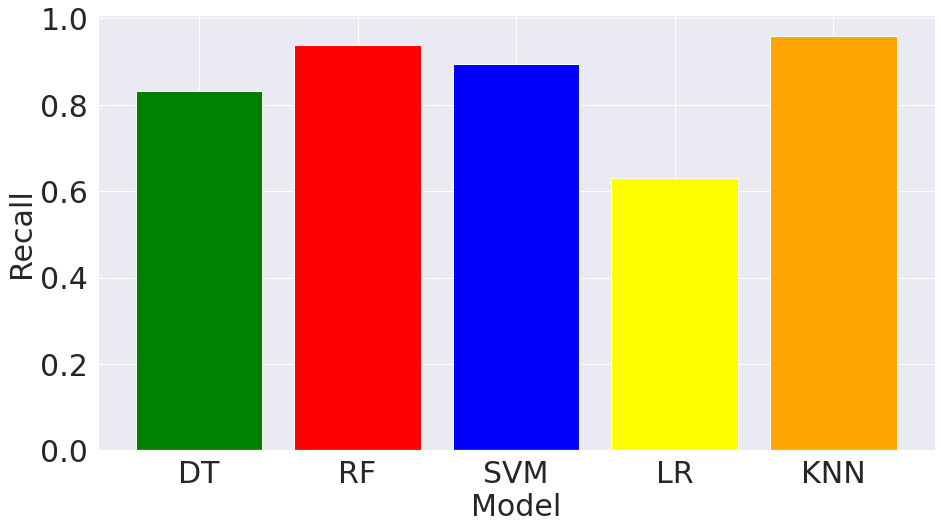

In [91]:
label_models=["DT","RF","SVM","LR","KNN"]
plt.figure(figsize=(15,8))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.bar(label_models,best_recall,color=["green","red","blue","yellow","orange"])
plt.ylabel('Recall',fontsize=30)
plt.xlabel('Model',fontsize=30)
plt.savefig("recall.png")

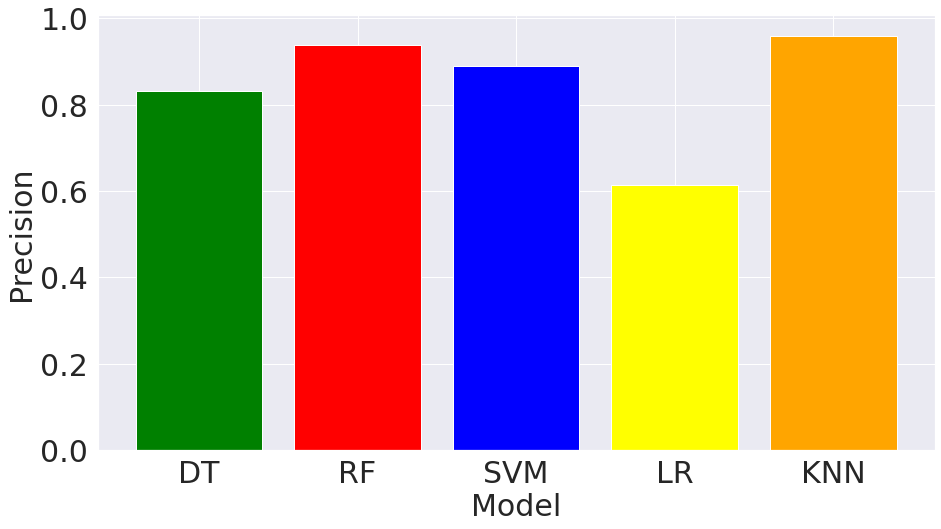

In [92]:
plt.figure(figsize=(15,8))
plt.bar(label_models,best_precision,color=["green","red","blue","yellow","orange"])
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylabel('Precision',fontsize=30)
plt.xlabel('Model',fontsize=30)
plt.savefig("precision.png")

In [93]:
#cross validation with the best model
clf = KNeighborsClassifier(5,weights="distance")
cv_results = cross_val_score(clf, X_train_norm, y_train, cv=5,scoring="f1_macro")
print(f"f1 score for each fold: {cv_results}")

f1 score for each fold: [0.95121311 0.94481501 0.95115102 0.9554635  0.95752012]


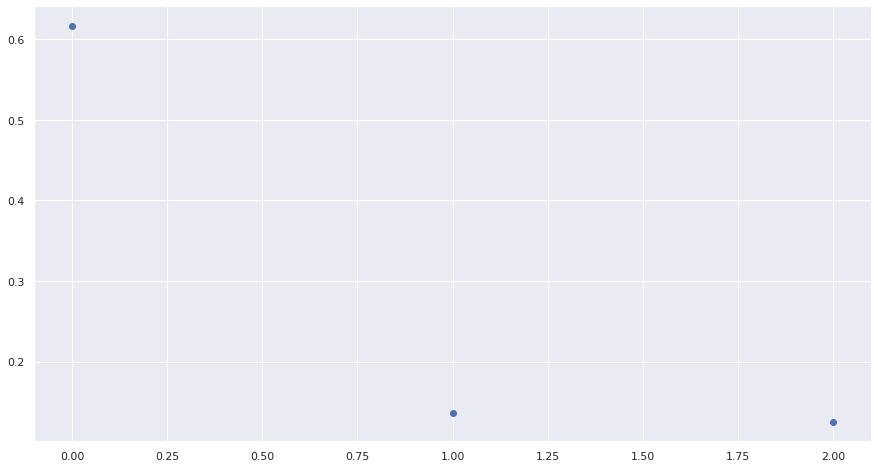

In [94]:
#PCA
pca = PCA(n_components=3)
X_projection = pca.fit_transform(X) 
plt.plot(pca.explained_variance_ratio_, marker='o', linestyle='') 

In [95]:

x1=[]
y1=[]
z1=[]
for i in X_projection:
    x1.append(i[0])
    y1.append(i[1])
    z1.append(i[2])
lab=np.array([int(num) for num in Y.values]) 

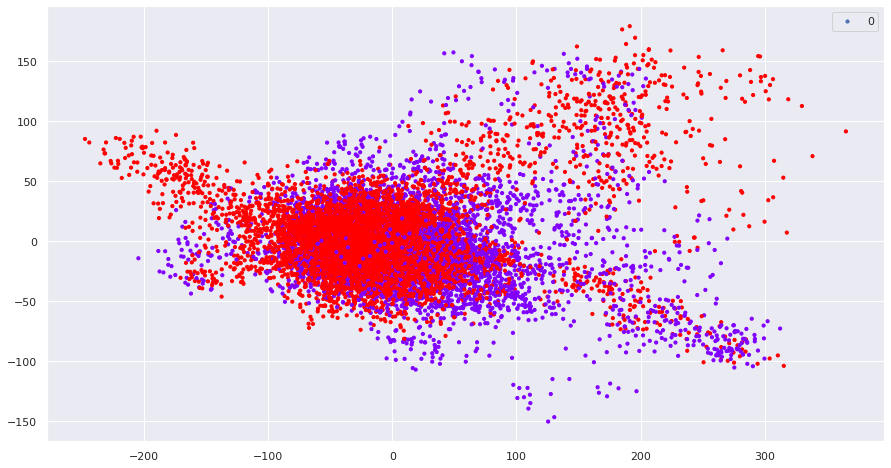

In [96]:
#plot dataset in two features
plt.figure(figsize=(15,8))
plt.scatter(x1,y1, s=10, c=lab,cmap='rainbow_r')
plt.legend([0,1])
plt.show()

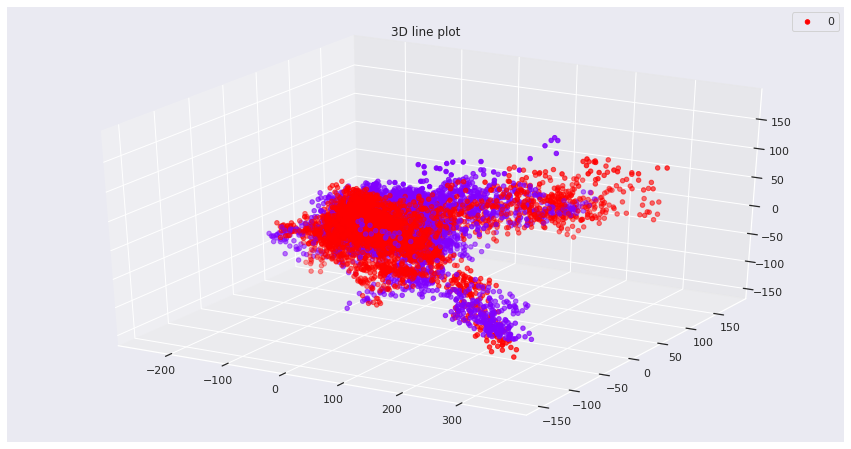

In [97]:

# plot dataset in 3 features
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 

 
# plotting
cmhot = plt.get_cmap("hot")
ax.scatter3D(x1, y1, z1,c=lab,cmap='rainbow_r')
ax.set_title('3D line plot')
plt.legend(["0","1"])
plt.savefig("3dplot.png")
plt.show()